# Selecting Context in LangGraph

*Selecting context means pulling it into the context window to help an agent perform a task.*

## Scratchpad

The mechanism for selecting context from a scratchpad depends upon how the scratchpad is implemented. If it’s a [tool](https://www.anthropic.com/engineering/claude-think-tool), then an agent can simply read it by making a tool call. If it’s part of the agent’s runtime state, then the developer can choose what parts of state to expose to an agent each step. This provides a fine-grained level of control for exposing context to an agent.

### Scratchpad selecting in LangGraph

Within each node (step) of a LangGraph agent, you can fetch state. This give you a great deal of control over what context you present to LLM calls. 

In [15]:
from typing import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str

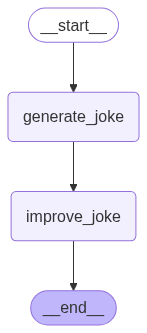

In [16]:
import os
import getpass
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

from langchain.chat_models import init_chat_model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    # Write the joke to state
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    print(f"Initial joke: {state['joke']}")
    # Select the joke from state to present it to the LLM
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", "improve_joke")
workflow.add_edge("improve_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [17]:
# Invoke
joke_generator_state = chain.invoke({"topic": "cats"})

# See joke is in state
joke_generator_state

Initial joke: Why don't cats ever win races?

Because they always paws right before the finish line!


{'topic': 'cats',
 'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"}

## Memory

If agents have the ability to save memories, they also need the ability to select memories relevant to the task they are performing. This can be useful for a few reasons. Agents might select few-shot examples ([episodic](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) [memories](https://arxiv.org/pdf/2309.02427)) for examples of desired behavior, instructions ([procedural](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) [memories](https://arxiv.org/pdf/2309.02427)) to steer behavior, or facts ([semantic](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) [memories](https://arxiv.org/pdf/2309.02427)) give the agent task-relevant context.

One challenge is ensure that relevant memories are selected. Some popular agents simply use a narrow set of files to store memories. For example, many code agent use “rules” files to save instructions (”procedural” memories) or, in some cases, examples (”episodic” memories). Claude Code uses [`CLAUDE.md`](http://CLAUDE.md). [Cursor](https://docs.cursor.com/context/rules) and [Windsurf](https://windsurf.com/editor/directory) use rules files. These are always pulled into context.

But, if an agent is storing a larger [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of facts and / or relationships ([semantic](https://langchain-ai.github.io/langgraph/concepts/memory/#memory-types) memories), selection is harder. [ChatGPT](https://help.openai.com/en/articles/8590148-memory-faq) is a good example of this. At the AIEngineer World’s Fair, [Simon Willison shared](https://simonwillison.net/2025/Jun/6/six-months-in-llms/) a good example of memory selection gone wrong: ChatGPT fetched his location and injected it into an image that he requested. This type of erroneous memory retrieval can make users feel like the context winder “*no longer belongs to them*”! Use of embeddings and / or [knowledge](https://arxiv.org/html/2501.13956v1#:~:text=In%20Zep%2C%20memory%20is%20powered,subgraph%2C%20and%20a%20community%20subgraph) [graphs](https://neo4j.com/blog/developer/graphiti-knowledge-graph-memory/#:~:text=changes%20since%20updates%20can%20trigger,and%20holistic%20memory%20for%20agentic) for indexing of memories have been used to assist with selection.

### Memory selecting in LangGraph

LangGraph’s long-term memory is accessible within each node and supports various types of retrieval (e.g., fetching files as well as [embedding-based retrieval across memory collection).](https://langchain-ai.github.io/langgraph/cloud/reference/cli/#adding-semantic-search-to-the-store)

In [18]:
from langgraph.store.memory import InMemoryStore
store = InMemoryStore()

# Define namespace (user_id, application_context)
namespace = ("rlm", "joke_generator")

# Store joke
store.put(
    namespace, # namespace
    "last_joke", # key
    {"joke": joke_generator_state["joke"]} # value
)

# Select joke 
store.get(namespace, "last_joke").value

{'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"}

In [11]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

# Initialize storage and checkpointer
checkpointer = InMemorySaver()
memory_store = InMemoryStore()

# Nodes
def generate_joke(state: State, store: BaseStore):
    """First LLM call to generate initial joke"""

    # Select prior joke, if any 
    prior_joke = store.get(namespace, "last_joke")
    if prior_joke:
        prior_joke = prior_joke.value["joke"]
    else:
        prior_joke = "None!"
    print(f"Prior joke: {prior_joke}")

    # Generate joke
    msg = llm.invoke(f"Write a short joke about {state['topic']}, but make it different from any prior joke you've written: {prior_joke}")

    # Store joke in memory
    store.put(namespace, "last_joke", {"joke": msg.content})

    # Write the joke to state
    return {"joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Re-compile with checkpointing and memory  
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

In [12]:
# Invoke
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: None!


In [13]:
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: Why don't cats ever win at poker?

Because they can't help but purr when they have a good hand!


## Tools

Agents use tools, but can become overloaded if they are provided with too many. This is often because the tool descriptions can overlap, causing model confusion about which tool to use. One approach is to apply RAG to tool descriptions in order to fetch the most relevant tools for a task based upon semantic similarity, an idea that Drew Breunig calls “[tool loadout](https://www.dbreunig.com/2025/06/26/how-to-fix-your-context.html).” Some [recent papers](https://arxiv.org/abs/2505.03275) have shown that this improve tool selection accuracy by 3-fold.

### Tool selecting in LangGraph

For tool selection, the [LangGraph Bigtool](https://github.com/langchain-ai/langgraph-bigtool) library is a great way to apply semantic similarity search over tool descriptions for selection of the most relevant tools for a task. It leverages LangGraph's long-term memory store to allow an agent to search for and retrieve relevant tools for a given problem.

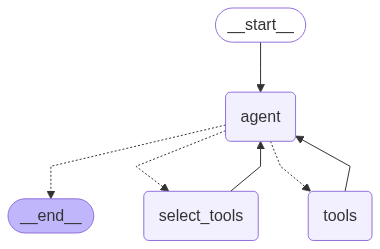

In [23]:
import math
import types
import uuid

from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

_set_env("OPENAI_API_KEY")

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent

In [24]:
query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": query})
# TODO: use format_mesages from utils file  
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Use available tools to calculate arc cosine of 0.5.
================================== Ai Message ==================================
Tool Calls:
  retrieve_tools (call_xEWpIztmXw2IgjWMIw7I7hKL)
 Call ID: call_xEWpIztmXw2IgjWMIw7I7hKL
  Args:
    query: arc cosine calculation
================================= Tool Message =================================

Available tools: ['cos', 'acos']
================================== Ai Message ==================================
Tool Calls:
  acos (call_uSjAkhEW5qbvHbVrW7o45xIV)
 Call ID: call_uSjAkhEW5qbvHbVrW7o45xIV
  Args:
    x: 0.5
================================= Tool Message =================================
Name: acos

1.0471975511965976
================================== Ai Message ==================================

The arc cosine of 0.5 is approximately \( 1.0472 \) radians.


### Learn more

* TODO: Read this paper and give a quick summary: Toolshed: Scale Tool-Equipped Agents with Advanced RAG-Tool Fusion and Tool Knowledge Bases - Lumer, E., Subbiah, V.K., Burke, J.A., Basavaraju, P.H. & Huber, A. (2024). arXiv:2410.14594.

* TODO: Read this paper and give a quick summary: Graph RAG-Tool Fusion - Lumer, E., Basavaraju, P.H., Mason, M., Burke, J.A. & Subbiah, V.K. (2025). arXiv:2502.07223.

* TODO: Read this repo README and give a quick summary:  https://github.com/quchangle1/LLM-Tool-Survey

* TODO: Read this paper and give a quick summary: Retrieval Models Aren't Tool-Savvy: Benchmarking Tool Retrieval for Large Language Models - Shi, Z., Wang, Y., Yan, L., Ren, P., Wang, S., Yin, D. & Ren, Z. arXiv:2503.01763.

## Knowledge 

[RAG](https://github.com/langchain-ai/rag-from-scratch) (retrieval augmented generation) is an extremely rich topic. Code agents are some of the best examples of agentic RAG in large-scale production. [In practice, RAG is can be a central context engineering challenge](https://x.com/_mohansolo/status/1899630246862966837). Varun from Windsurf captures some of these challenges well:

> Indexing code ≠ context retrieval … [We are doing indexing & embedding search … [with] AST parsing code and chunking along semantically meaningful boundaries … embedding search becomes unreliable as a retrieval heuristic as the size of the codebase grows … we must rely on a combination of techniques like grep/file search, knowledge graph based retrieval, and … a re-ranking step where [context] is ranked in order of relevance. 

### RAG in LangGraph

There are several [tutorials and videos](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) that show how to use RAG with LangGraph. When combining RAG with agents in LangGraph, it's common to build a retrieval tool. Note that this tool could incorporate any combination of RAG techniques, as mentioned above.

Fetch documents to use in our RAG system. We will use three of the most recent pages from Lilian Weng's excellent blog. We'll start by fetching the content of the pages using WebBaseLoader utility.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

Split the fetched documents into smaller chunks for indexing into our vectorstore.

In [41]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

Now that we have our split documents, we can index them into a vector store that we'll use for semantic search.

In [42]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

Create a retriever tool that we can use in our agent.

In [43]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

retriever_tool.invoke({"query": "types of reward hacking"})

'Experiments in two RL environments, CoinRun and Maze, demonstrated the importance of randomization during training. If during training, the coin or the cheese is placed at a fixed position (i.e. right end of the level or upper right corner of the maze) but testing in the env where the coin or cheese is placed at random, the agent would just run to the fixed position without obtaining the coin or cheese at test time. A conflict arises when a visual feature (e.g., cheese or coin) and a positional feature (e.g., upper-right or right end) are inconsistent during test time, leading the trained model to prefer the positional feature. I would like to point out that, in these two examples, the reward-result gaps are clear but such type of biases are unlikely to be so obvious in most real-world cases.\n\n\nThe impact of randomizing the position of the coin during training. When the coin is placed at random for {0, 2, 3, 6, 11}% of the time during training (x-axis), the frequency of the agent n

Now, implement an agent that can select context from the tool.

In [44]:
# Augment the LLM with tools
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

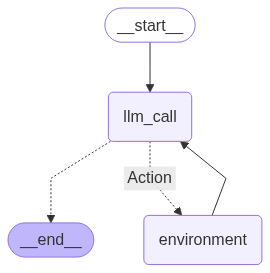

In [45]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal

rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=rag_prompt
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": query})
# TODO: use format_mesages from utils file  
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What does Lilian Weng say about types of reward hacking?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_pIeeEvWXP7hJcdvVmabb1xEa)
 Call ID: call_pIeeEvWXP7hJcdvVmabb1xEa
  Args:
    query: types of reward hacking
================================= Tool Message =================================

Experiments in two RL environments, CoinRun and Maze, demonstrated the importance of randomization during training. If during training, the coin or the cheese is placed at a fixed position (i.e. right end of the level or upper right corner of the maze) but testing in the env where the coin or cheese is placed at random, the agent would just run to the fixed position without obtaining the coin or cheese at test time. A conflict arises when a visual feature (e.g., cheese or coin) and a positional feature (e.g., upper-right or right end) are inco